In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, beta
from tabulate import tabulate

seed = np.random.seed(11) # seed pour avoir les mêmes résultats

### Création des tables utiles de rating et de secteur

In [404]:
# paramètres 

corr = 0.1 # corrélation
number_of_simulations = 100000 # nombre de simulations monte-carlo

# table de rating
rating_df = pd.DataFrame({
    "Rating": ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "CC", "C"],
    "1Y": [0.0003, 0.0010, 0.005, 0.0124, 0.0376, 0.0705, 0.15, 0.25, 0.5]
})

# table des corrélations des différents secteurs
secteur_df = pd.DataFrame({
    "Secteur": ["techno", "utilities", "consumer"],
    "Corr_Sectorielle": [0.17, 0.12, 0.15],
    "Num_Secteur": [i for i in range(len(secteur_df.Secteur))]
})

# table regroupant tous nos CDS
CDS_df = pd.read_excel("csv_test.xlsx")

### Calcul de PD, Barrier, Expected Loss et Correlation Sectorielle

In [405]:
# calcul des probabilités de défault
PD_list = []
for rating in CDS_df.Rating:
    for i in range(len(rating_df)):
        if rating_df.Rating[i] == rating:
            PD_list.append(rating_df["1Y"][i])
            
CDS_df["PD"] = PD_list

# calcul des barrières avec l'inverse de la CDF de la loi normale et une loi exponentielle
lambda_barrier = 0.5
CDS_df["Barrier"] = norm.ppf(CDS_df["PD"]) - lambda_barrier * np.log(np.random.uniform(0, 1, size=(1, len(CDS_df.index)))[0])

# calcul des expected loss
CDS_df["Expected_Loss"] = CDS_df.Nominal*CDS_df.LGD*CDS_df.PD

#calcul des coorélations sectorielles
corr_list = []
num_secteur_array = np.zeros((len(CDS_df.index), len(secteur_df.index))) # tableau pour les poids des échantillons sectorielles

for index, secteur in enumerate(CDS_df.Secteur):
    for j in range(np.shape(num_secteur_array)[1]):
        if secteur_df.Secteur[j] == secteur:
            corr_list.append(secteur_df["Corr_Sectorielle"][j])
            num_secteur_array[index, j] = 1 # on renseigne 1 dans les poids pour le X correspondant au secteur

CDS_df["Corr_Sectorielle"] = corr_list

### Monte Carlo

In [406]:
N_CDS = len(CDS_df.index) #nombre de CDS

MC_X_samples = np.random.normal(0, 1, size=(number_of_simulations, 1)) # échantillons gaussiens X 
MC_Xsecteurs_samples = np.random.normal(0, 1, size=(number_of_simulations, len(secteur_df.index))) # échantillons gaussiens X des secteurs
MC_error_samples = np.random.normal(0, 1, size=(number_of_simulations, N_CDS)) # termes d'erreurs gaussiens

# produit matriciel pour ne garder que les bons X par secteurs
X_secteurs = np.dot(MC_Xsecteurs_samples, num_secteur_array.T) # on crée une matrice (nombre de simulations * nombre de CDS) pour les différents secteurs

Z_matrix = np.sqrt(corr)*MC_X_samples + np.sqrt(list(CDS_df["Corr_Sectorielle"] - corr))* X_secteurs + np.sqrt(1 - corr)* MC_error_samples # matrice des Zi

Default_matrix = Z_matrix < ([list(CDS_df.Barrier)] * number_of_simulations) # matrice des défaults

# calcul des LGD suivant une loi beta
LGD_beta_matrix = beta.ppf(np.random.uniform(0, 1, size=(number_of_simulations, N_CDS)), 0.45, 0.45)

Loss_matrix = Default_matrix * LGD_beta_matrix * ([list(CDS_df.Nominal)]* number_of_simulations) # matrice des pertes

In [407]:
# calcul des pertes du protefeuille pour chaque simulation
Loss_Portfolio = []
for i in range(np.shape(Default_matrix)[0]):
    Loss_Portfolio.append(Loss_matrix[i,:].sum()) # on ajoute la perte totale du portfolio sur la simulation i

## Portfolio Management

In [408]:
var_precision = 99 # précision de la var en pourcentages

perte_moyenne = pd.Series(Loss_Portfolio).mean() # perte moyenne du portfolio
var = pd.Series(Loss_Portfolio).quantile(var_precision/100) # var (souvent à 99%)

sum_loss_sup_var = 0 # somme des pertes supérieures à la var
counter = 0
for loss in Loss_Portfolio:
    if loss > var:
        sum_loss_sup_var += loss
        counter += 1
        
esf = sum_loss_sup_var / counter # expected shortfall

portfolio_mgt = pd.DataFrame({
    "Portfolio Management": ["Perte Moyenne", f"VaR ({var_precision}%)", "ESF"],
    "Value": [perte_moyenne, var, esf]
        })

In [409]:
print(tabulate(portfolio_mgt, headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════╤══════════╕
│ Portfolio Management   │    Value │
╞════════════════════════╪══════════╡
│ Perte Moyenne          │  8255.18 │
├────────────────────────┼──────────┤
│ VaR (99%)              │ 29445.4  │
├────────────────────────┼──────────┤
│ ESF                    │ 33655.7  │
╘════════════════════════╧══════════╛


## CDO

In [410]:
strike = 0.05
size = 0.02

Loss_CDO = Loss_Portfolio / CDS_df.Nominal.sum() # liste des pertes pour chaque simulation de notre CDO

Loss_tranche = [] # perte de notre tranche en pourcentage (de 0 à 1)
for loss in Loss_CDO:
    Loss_tranche.append(min(max(loss - strike, 0), size) / size)
    
price = pd.Series(Loss_tranche).mean()

cdo_mgt = pd.DataFrame({
    "CDO Management": ["Strike", "Size", "Price"],
    "Value": [f"{strike*100}%", f"{size*100}%", f"{price*100}%"]
        })

In [411]:
print(tabulate(cdo_mgt, headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════════════════╤═══════════════════╕
│ CDO Management   │ Value             │
╞══════════════════╪═══════════════════╡
│ Strike           │ 5.0%              │
├──────────────────┼───────────────────┤
│ Size             │ 2.0%              │
├──────────────────┼───────────────────┤
│ Price            │ 58.1836003627578% │
╘══════════════════╧═══════════════════╛


## Convergence

In [412]:
moyenne_glissante = pd.Series(Loss_Portfolio).expanding().mean()
#error = moyenne_glissante + (1/number_of_simulations)*(perte_moyenne - moyenne_glissante)**2
#error2 = moyenne_glissante - (1/number_of_simulations)*(perte_moyenne - moyenne_glissante)**2


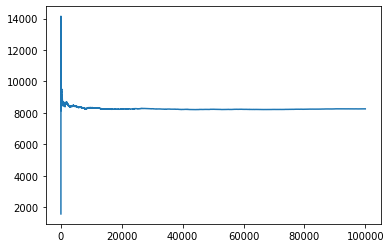

In [413]:
plt.plot(moyenne_glissante.index, moyenne_glissante)
#plt.plot(error.index, error)
#plt.plot(error2.index, error2)

plt.show()